In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [80]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
# Read the data
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.head())
display(train_data.tail())
display(train_data.isnull().sum())
display(train_data.shape)



,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
0,2020-01-01,25.2,32.0,27.0,82.0,16.5,6.5,7.0,300.0,3.000000,-0.221338
1,2020-01-02,25.6,31.0,27.9,78.0,5.2,3.5,8.0,270.0,4.000000,-0.200959
2,2020-01-03,25.3,31.5,27.6,82.0,1.5,5.9,10.0,280.0,6.000000,-0.158172
3,2020-01-04,26.5,30.5,27.9,77.0,1.7,4.6,12.0,260.0,8.000000,-0.125176
4,2020-01-05,25.6,31.3,28.6,81.0,8.1,8.0,5.0,6.0,3.133748,-0.127169


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,rad(m)
726,2022-12-27,25.5,29.5,27.5,83.0,6.0,1.2,9.0,270.0,6.0,-0.024320
727,2022-12-28,24.5,29.1,26.9,84.0,2.3,0.0,9.0,270.0,5.0,-0.030015
728,2022-12-29,24.0,30.1,27.0,84.0,35.6,3.2,8.0,260.0,4.0,0.005127
729,2022-12-30,25.9,30.0,27.6,83.0,1.0,4.9,7.0,310.0,3.0,-0.058673
730,2022-12-31,24.9,32.2,27.7,83.0,0.0,0.6,7.0,280.0,3.0,-0.401817


Date      0
Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ddd_x     0
ff_avg    0
rad(m)    0
dtype: int64

(731, 11)

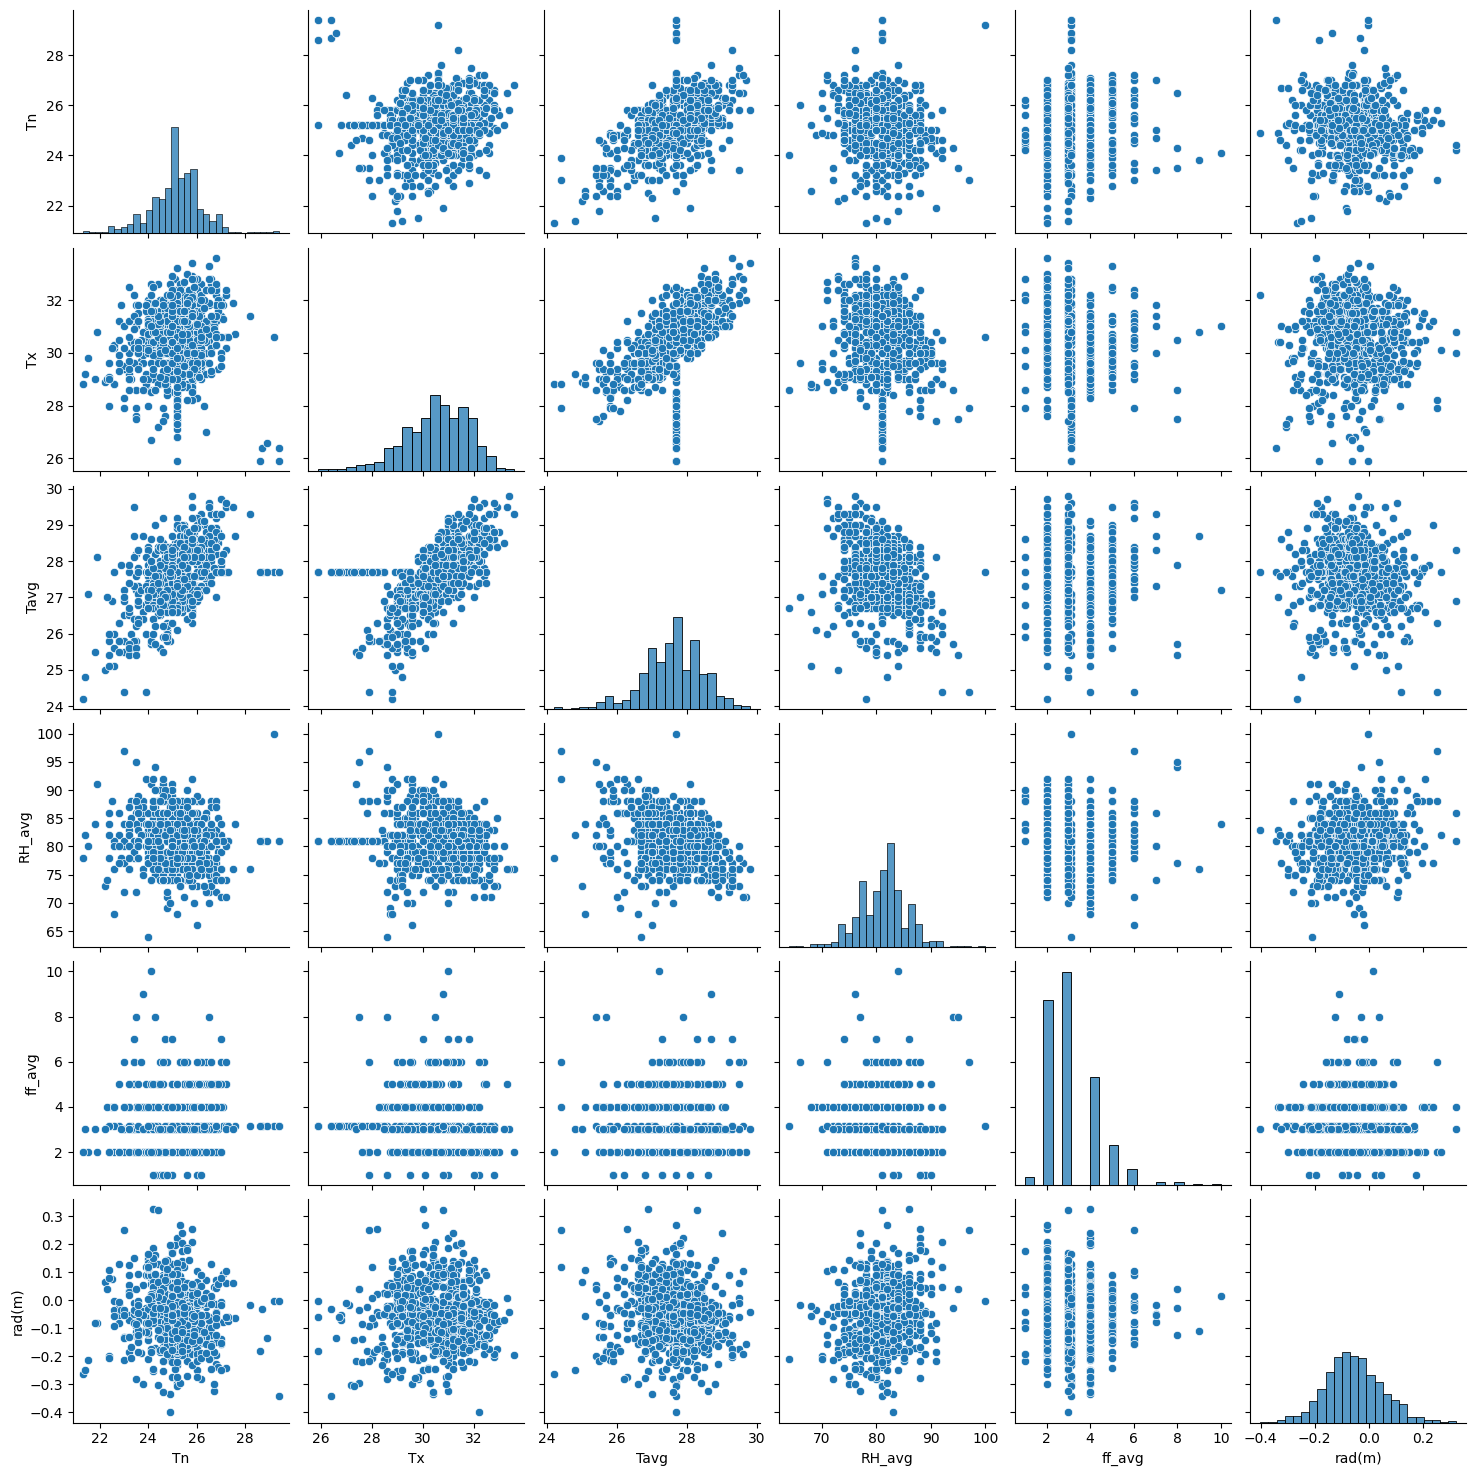

In [81]:
# Pair plot to visualize relationships between features
sns.pairplot(train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']])
plt.show()

Linear Regression Process Start Here


In [82]:
# Custom Accuracy Metric for Regression: Predictions within a tolerance range
class RegressionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="regression_accuracy", tolerance=0.05, **kwargs):
        super().__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.correct_predictions = self.add_weight(name="correct_predictions", initializer="zeros")
        self.total_predictions = self.add_weight(name="total_predictions", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        within_tolerance = tf.cast(error <= self.tolerance, tf.float32)
        self.correct_predictions.assign_add(tf.reduce_sum(within_tolerance))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)
        
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [83]:
def classify_rules(row):
    # Kondisi "Tidak Aman" - suhu sangat tinggi atau angin sangat kencang
    if row['Tx'] > 40 or row['ff_avg'] > 1.5:  # Suhu sangat tinggi atau angin sangat kencang
        return 'Tidak Aman'
    
    # Kondisi "Tidak Aman" - suhu sangat tinggi dan kelembapan sangat tinggi
    elif row['Tx'] > 38 and row['RH_avg'] > 85:  # Suhu sangat tinggi dan kelembapan sangat tinggi
        return 'Tidak Aman'
    
    # Kondisi "Tidak Aman" - suhu rendah dan radiasi tinggi
    elif row['Tn'] < 5 and row['rad(m)'] > 800:  # Suhu rendah dan radiasi sangat tinggi
        return 'Tidak Aman'
    
    # Kondisi "Risiko" - suhu tinggi dan kelembapan sangat tinggi
    elif row['Tavg'] > 32 and row['RH_avg'] > 75:  # Suhu tinggi dan kelembapan sangat tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu tinggi dan radiasi sangat tinggi
    elif row['Tavg'] > 32 and row['rad(m)'] > 700:  # Suhu tinggi dan radiasi sangat tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu moderat dan kelembapan tinggi
    elif 25 <= row['Tavg'] <= 30 and row['RH_avg'] > 65:  # Suhu sedang dan kelembapan tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu sedang dan angin sedang
    elif 25 <= row['Tavg'] <= 30 and 0.5 < row['ff_avg'] <= 1.0:  # Suhu sedang tinggi dan angin sedang
        return 'Risiko'
    
    # Kondisi "Aman" - suhu rendah dengan kelembapan rendah
    elif row['Tn'] < 15 and row['RH_avg'] < 50:  # Suhu rendah dan kelembapan rendah
        return 'Aman'
    
    # Kondisi "Aman" - suhu moderat dan angin ringan
    elif 15 <= row['Tavg'] <= 25 and row['ff_avg'] < 0.3:  # Suhu moderat dan angin ringan
        return 'Aman'
    
    # Kondisi "Aman" - suhu sedang dan kelembapan sedang
    elif 20 <= row['Tavg'] <= 28 and 40 <= row['RH_avg'] <= 60:  # Suhu sedang dan kelembapan sedang
        return 'Aman'
    
    # Jika tidak ada kondisi lain yang memenuhi, anggap kondisi sebagai "Aman"
    return 'Aman'




Epoch 1/150


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1710 - loss: 2.1236 - val_accuracy: 0.9864 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8008 - loss: 0.5670 - val_accuracy: 0.9864 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.2054 - val_accuracy: 0.9864 - val_loss: 0.2312 - learning_rate: 0.0010
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.1673 - val_accuracy: 0.9864 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0902 - val_accuracy: 0.9864 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9801 - loss: 0.1026 - val_accuracy: 0.9864 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.0605 - val_accuracy: 0.986

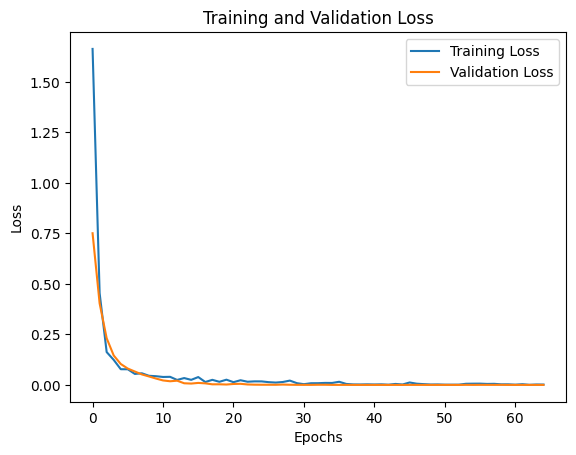

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2394e-04 
Final Loss: 0.0001
Final Accuracy: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 1.0000
              precision    recall  f1-score   support

      Risiko       1.00      1.00      1.00         2
  Tidak Aman       1.00      1.00      1.00       145

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147



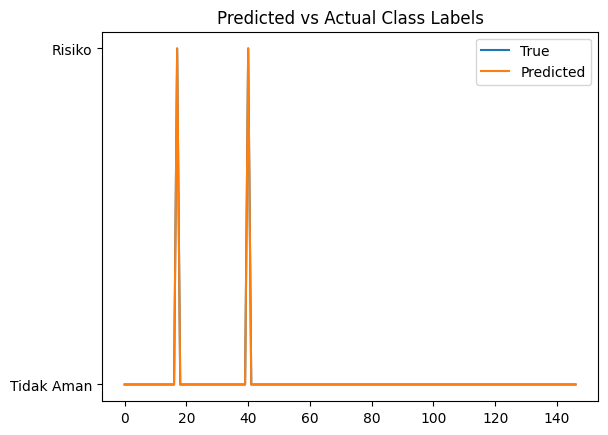

In [84]:
X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']]
# Terapkan fungsi untuk menentukan kondisi
train_data['prediction'] = train_data.apply(classify_rules, axis=1)
y = train_data['prediction']

# Apply function untuk mengubah target menjadi label kategori

# Encode label menjadi numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Membangun model neural network untuk klasifikasi
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Output layer untuk 3 kelas
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Karena kita menggunakan label yang sudah terencode
              metrics=['accuracy'])

# Implementasi learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

# Implementasi early stopping untuk menghentikan training lebih awal jika model tidak berkembang
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, validation_data=(X_test_scaled, y_test),
                    batch_size=16, verbose=1, callbacks=[lr_scheduler, early_stopping])

# Visualisasi training history
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")

# Prediksi kelas
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hitung akurasi
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes):.4f}")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Plot predictions vs actual values (kelas)
plt.figure()
plt.plot(label_encoder.inverse_transform(y_test), label="True")
plt.plot(label_encoder.inverse_transform(y_pred_classes), label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Class Labels")
plt.show()

In [85]:
def test_model(model, X_test_scaled, y_test, label_encoder):
    """
    Fungsi untuk menguji model klasifikasi dan memberikan evaluasi.
    
    Parameters:
        model (tensorflow.keras.models.Sequential): Model yang telah dilatih
        X_test_scaled (ndarray): Fitur uji yang sudah diskalakan
        y_test (ndarray): Label uji
        label_encoder (sklearn.preprocessing.LabelEncoder): Label encoder untuk mengubah label numerik kembali ke bentuk asli

    Returns:
        None
    """
    # Prediksi kelas menggunakan model
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")

    # Tampilkan classification report (precision, recall, f1-score per kelas)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [86]:
X_test_scaled = {
    'Tn': 24.5,      # Minimum temperature
    'Tx': 30.0,      # Maximum temperature
    'Tavg': 28.0,    # Average temperature
    'RH_avg': 80.0,  # Average relative humidity
    'ff_avg': 3.0,   # Average wind speed
    'rad(m)': -0.01  # Solar radiation
}

# Convert the input dictionary into a pandas DataFrame
input_df = pd.DataFrame([X_test_scaled])  # DataFrame expects a list of dictionaries

# As your model was trained on these features: ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']
# Ensure that the DataFrame columns match the training set
input_df = input_df[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']]

# Normalisasi data menggunakan scaler yang sudah dilatih
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_df)  # Gunakan fit_transform hanya jika scaler baru, atau scaler sebelumnya

# Prediksi menggunakan model
y_pred = model.predict(input_scaled)

# Output prediksi kelas
y_pred_class = np.argmax(y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Mengembalikan hasil prediksi kelas ke label asli
predicted_label = label_encoder.inverse_transform(y_pred_class)

print(f"Predicted class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Tidak Aman
